In [ ]:
#This study doesnot have upgrade to improve results
import pandas as pd
import numpy as np
import datetime as dt
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing

In [ ]:
df=pd.read_csv("/content/municipality_bus_utilization.csv")

df['timestamp'] = df['timestamp'].values.astype(dtype='datetime64[ms]')
df['usage'] = df['usage'].values.astype(dtype='float64')

def take_len(df):
    list_municipality_id=df.groupby([pd.Grouper(key='municipality_id')])["municipality_id"].max()
    a = df[df["municipality_id"]== list_municipality_id[0]]
    a=a.groupby([pd.Grouper(key='timestamp',freq='1H')]).max().reset_index()
    a=a.interpolate(method='linear', limit_direction='forward', axis=0)
    a=a.sort_values(by=['timestamp'])
    a['usage'] = a['usage'].values.astype(dtype='float64')
    return len(a['usage'])


def take_data(df,low_date_time,high_date_time):
    df = df[df["timestamp"]>= low_date_time ]
    df = df[df["timestamp"]<= high_date_time ]
    list_municipality_id=df.groupby([pd.Grouper(key='municipality_id')])["municipality_id"].max()
    data=np.zeros([take_len(df),len(list_municipality_id)])
    for i in range(len(list_municipality_id)):
        a = df[df["municipality_id"]== list_municipality_id[i]]
        a=a.groupby([pd.Grouper(key='timestamp',freq='1H')]).max().reset_index()
        a=a.interpolate(method='linear', limit_direction='forward', axis=0)
        a=a.sort_values(by=['timestamp'])
        a['usage'] = a['usage'].values.astype(dtype='float64')
        data[:,i]=a["usage"].to_numpy()
    return data

train_data=take_data(df,"2017-01-01","2017-08-04")
test_data=take_data(df,"2017-08-04","2017-08-20")

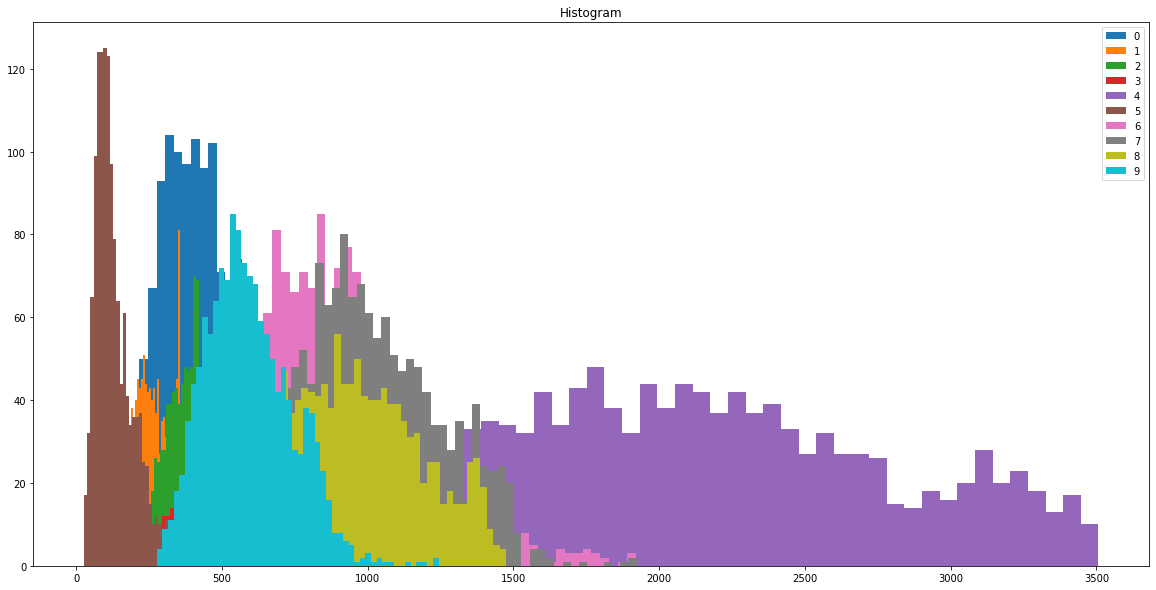

In [ ]:
list_municipality_id=df.groupby([pd.Grouper(key='municipality_id')])["municipality_id"].max()
plt.figure(figsize=(20,10))
for i in range(len(list_municipality_id)):
    plt.hist(train_data[:,i] ,50,label = list_municipality_id[i])

plt.title("Histogram")
plt.legend()
plt.show()

In [ ]:
results=[]
for i in range(len(list_municipality_id)):
    model = ARIMA(train_data[:,i], order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps=len(test_data))
    print("------------------------------------------------------")
    print(" For  :"+np.str(list_municipality_id[k]))
    print(model_fit.summary())
    results.append(output)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1425
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -7710.344
Method:                       css-mle   S.D. of innovations             54.145
Date:                Thu, 09 Sep 2021   AIC                          15434.688
Time:                        09:50:33   BIC                          15471.521
Sample:                             1   HQIC                         15448.445
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3226      2.454      0.131      0.895      -4.488       5.133
ar.L1.D.y      0.5236      0.026     19.890      0.000       0.472       0.575
ar.L2.D.y      0.0830      0.030      2.801      0.0

In [ ]:
y_pred=results[0][0]
for j in range(1,len(results)):
    a=results[j][0]
    y_pred=np.concatenate((y_pred,a))
    

In [ ]:
from sklearn.metrics import r2_score,mean_squared_error,explained_variance_score

y_true=np.reshape(test_data,(len(test_data),len(list_municipality_id)))
y_pred=np.reshape(y_pred,(len(test_data),len(list_municipality_id)))


for k in range(len(list_municipality_id)):
  print("------------------------------------------------------")
  print(" For  :"+np.str(list_municipality_id[k]))
  print("R2 Score",r2_score(y_true[:,k], y_pred[:,k]))
  print("Explained Variance Score",explained_variance_score(y_true[:,k], y_pred[:,k]))
  print("Mean Squared Error",mean_squared_error(y_true[:,k], y_pred[:,k]))

------------------------------------------------------
 For  :0
R2 Score -3.612343559164784
Explained Variance Score -3.24851197384982
Mean Squared Error 372465.02811940876
------------------------------------------------------
 For  :1
R2 Score -83.14923671292324
Explained Variance Score -42.53189135615634
Mean Squared Error 476691.925506847
------------------------------------------------------
 For  :2
R2 Score -33.35436400802982
Explained Variance Score -23.9179069654954
Mean Squared Error 356093.2495325282
------------------------------------------------------
 For  :3
R2 Score -3.71377338393485
Explained Variance Score -3.2985496271413055
Mean Squared Error 439625.8965681439
------------------------------------------------------
 For  :4
R2 Score -4.731874659663665
Explained Variance Score -0.8532279624500334
Mean Squared Error 2806100.8908517817
------------------------------------------------------
 For  :5
R2 Score -73.2074312184288
Explained Variance Score -25.400934477291724

In [ ]:
results1=[]
for i in range(len(list_municipality_id)):
    model_fit1 =ExponentialSmoothing(train_data[:,i], trend='add' ,damped=True).fit(damping_slope=0.96,optimized=True)
    output1 = model_fit1.forecast(len(test_data))
    print("------------------------------------------------------")
    print(" For  :"+np.str(list_municipality_id[k]))
    print(model_fit1.summary())
    results1.append(output1)

------------------------------------------------------
 For  :9
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 1426
Model:             ExponentialSmoothing   SSE                        5099332.673
Optimized:                         True   AIC                          11677.520
Trend:                         Additive   BIC                          11703.833
Seasonal:                          None   AICC                         11677.599
Seasonal Periods:                  None   Date:                 Thu, 09 Sep 2021
Box-Cox:                          False   Time:                         09:54:39
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000             

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


------------------------------------------------------
 For  :9
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 1426
Model:             ExponentialSmoothing   SSE                         571600.290
Optimized:                         True   AIC                           8556.826
Trend:                         Additive   BIC                           8583.139
Seasonal:                          None   AICC                          8556.905
Seasonal Periods:                  None   Date:                 Thu, 09 Sep 2021
Box-Cox:                          False   Time:                         09:54:39
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000             

In [ ]:
y_pred=results1[0]
for j in range(1,len(results1)):
    a=results1[j]
    y_pred=np.concatenate((y_pred,a))
    

In [ ]:
from sklearn.metrics import r2_score,mean_squared_error,explained_variance_score

y_true=np.reshape(test_data,(len(test_data),len(list_municipality_id)))
y_pred=np.reshape(y_pred,(len(test_data),len(list_municipality_id)))


for k in range(len(list_municipality_id)):
  print("------------------------------------------------------")
  print(" For  :"+np.str(list_municipality_id[k]))
  print("R2 Score",r2_score(y_true[:,k], y_pred[:,k]))
  print("Explained Variance Score",explained_variance_score(y_true[:,k], y_pred[:,k]))
  print("Mean Squared Error",mean_squared_error(y_true[:,k], y_pred[:,k]))

------------------------------------------------------
 For  :0
R2 Score -127.08380540082055
Explained Variance Score -62.62626449587651
Mean Squared Error 10343275.076606909
------------------------------------------------------
 For  :1
R2 Score -1583.762385378401
Explained Variance Score -890.7393784154909
Mean Squared Error 8977424.662021164
------------------------------------------------------
 For  :2
R2 Score -932.1821843604683
Explained Variance Score -483.5513165580159
Mean Squared Error 9672712.216622956
------------------------------------------------------
 For  :3
R2 Score -126.28685816275667
Explained Variance Score -49.626280883498275
Mean Squared Error 11871296.004992139
------------------------------------------------------
 For  :4
R2 Score -38.30464727154986
Explained Variance Score -7.8267677659865935
Mean Squared Error 19242012.826879025
------------------------------------------------------
 For  :5
R2 Score -942.3688106342757
Explained Variance Score -574.730750